# Boundary conditions

In [1]:
import numpy as np
import scipy as sp
import os
import sys
from scipy import optimize
from scipy import integrate
from scipy import interpolate
from matplotlib import pyplot as plt

In [2]:
cs = 1/3**0.5

## Assuming Bag model

### Detonation case

In [3]:
def match(vp,vm,Tp,Tm,ap,am,εp, εm):
    r = ap*Tp**4/(am*Tm**4)
    αp = (εp-εm)/(ap*Tp**4)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

In [5]:
def guess_det(vp, Tp, ap, am, εp, εm):
    αp = (εp-εm)/(ap*Tp**4)
    r=1/(1+3*αp)
    Tm = (ap*Tp**4/(am*r))**0.25
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    vm = min(vpvm/vp,vp)
    return [vm,Tm]

In [7]:
guess_det(0.7,80,106.75, 106.75-7*12/8, 10**7,0)

[0.7, 82.23830742478549]

In [6]:
vw=0.7
gstar=106.75
gstar_no_top = 106.75 - 7*12/8
ε=1e7
Tn=80
optimize.fsolve(lambda x:match(vw, x[0], 80, x[1],gstar, gstar_no_top,ε,0),guess_det(vw,Tn,gstar,gstar_no_top,ε,0))

array([ 0.69470254, 82.55021068])

### Deflagration

#### Solve the matching equation

In [9]:
guess_sol = optimize.fsolve(lambda x:match(x[0], 0.5, x[1], 59,gstar, gstar_no_top,1e8,0),[0.3, 65])

In [11]:
guess_sol

array([ 0.3542054 , 65.12059431])

In [7]:
def dYda(tau, y):
    v = y[0]
    xi = y[1]
    dvdtau = 2 * v * cs**2 * (1-v**2) * (1- xi * v)
    dxidtau = xi *((xi-v)**2 - cs**2 * (1-xi*v)**2)
    return np.array([dvdtau, dxidtau])

In [8]:
def μ(x, v):
    return (x-v)/(1-x*v)

In [12]:
μ(0.5, guess_sol[0])

0.17717229597450568

#### Shooting method

In [120]:
vsol=integrate.solve_ivp(dYda, (10,1), np.array([μ(0.5, guess_sol[0]), 0.5]),t_eval=np.linspace(10,1,1000),method='DOP853')

In [121]:
vsol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e+01  9.991e+00 ...  1.009e+00  1.000e+00]
        y: [[ 1.772e-01  1.762e-01 ...  4.989e-04  4.959e-04]
            [ 5.000e-01  5.008e-01 ...  5.790e-01  5.790e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 62
     njev: 0
      nlu: 0

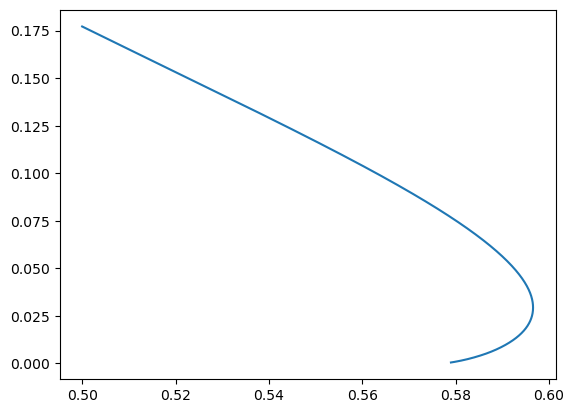

In [122]:
plt.plot(vsol.y[1],vsol.y[0])

In [123]:
xi_max = vsol.y[1].max()
xi_max_index = vsol.y[1].argmax()
v_prof = interpolate.UnivariateSpline(vsol.y[1][0:xi_max_index+1], vsol.y[0][0:xi_max_index+1], s=0)

In [124]:
vsol.t[xi_max_index]

7.1441441441441444

In [125]:
xi_max

0.5965608015134444

In [51]:
v_prof(0.55)

array(0.11681821)

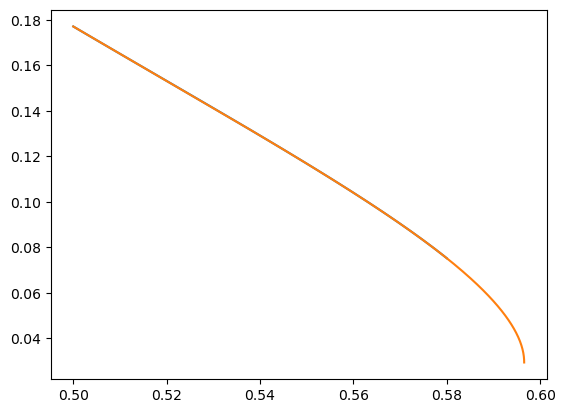

In [126]:
xplot = np.linspace(0.5, 0.58, 100)
vplot = [v_prof(x) for x in xplot]
plt.plot(xplot, vplot)
plt.plot(vsol.y[1][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])

In [127]:
vsol.y[0][xi_max_index+1]

0.029110592320081743

In [129]:
v_prof.derivative()(0.55)

array(-1.25385501)

In [130]:
tlist = np.array([0.5, 0.503217, 0.506433, 0.50965, 0.512867, 0.516083, 0.5193, 0.522517, 0.525733, 0.52895, 0.532167, 0.535383, 0.5386, 0.541817, 0.545034, 0.54825, 0.551467, 0.554684, 0.5579, 0.561117, 0.564334, 0.56755, 0.570767, 0.573984, 0.5772, 0.580417, 0.583634, 0.58685, 0.590067, 0.593284, 0.5965])
vlist = np.array([0.177172, 0.173294, 0.169428, 0.165572, 0.161724, 0.15788, 0.154038,0.150195, 0.146349, 0.142496, 0.138631, 0.134752, 0.130853, 0.126931, 0.122979, 0.11899, 0.114959, 0.110876, 0.106731, 0.102513, 0.0982061, 0.093793, 0.0892503, 0.0845472, 0.0796418, 0.0744743, 0.0689529, 0.0629241, 0.0560902, 0.04769, 0.0315993])

# This is the mathematica output for the velocity profile

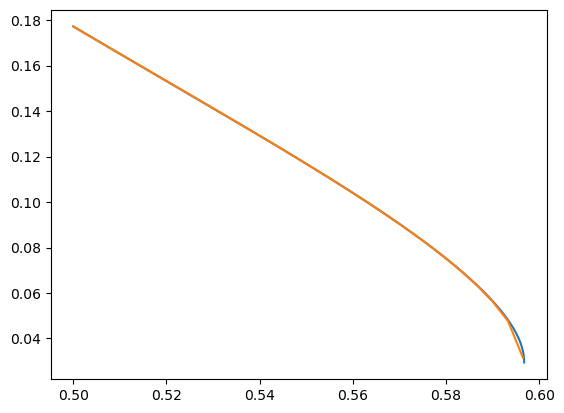

In [55]:
plt.plot(vsol.y[1][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
plt.plot(tlist, vlist)

This shows that the velocity profile has very good agreement with mathematica.

In [11]:
def dTdx(x, y):
    T = y[0]
    dT = T/(1-v_prof(x)**2)
    dT = dT * μ(x, v_prof(x)) * v_prof.derivative()(x)
    return np.array([dT])
    

In [132]:
Tsol=integrate.solve_ivp(dTdx, (0.5, xi_max*0.999), [guess_sol[1]], t_eval=np.linspace(0.5,xi_max*0.999, 1000),method='DOP853')

In [133]:
T_prof = interpolate.interp1d(Tsol.t,Tsol.y[0])

In [134]:
T_prof(0.52)

array(64.51929142)

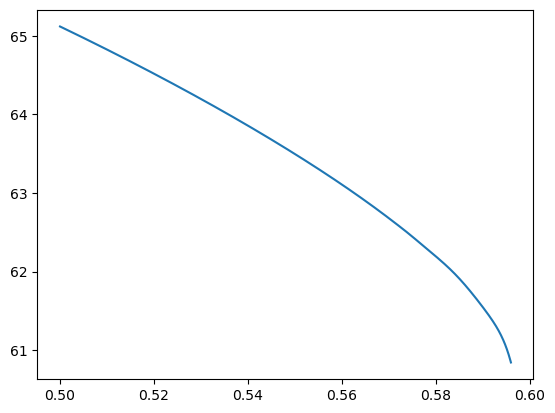

In [135]:
plt.plot(Tsol.t, Tsol.y[0])

In [136]:
xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - 1/3, 0.5, xi_max*0.999)

In [137]:
xsh

0.593373981687617

In [138]:
T_prof(xsh)

array(61.243257)

In [13]:
def find_Tsh(Tm):
    guess_sol = optimize.fsolve(lambda x:match(x[0], 0.5, x[1], Tm,gstar, gstar_no_top,1e8,0),[0.35, 60])
    vsol=integrate.solve_ivp(dYda, (10,0.01), np.array([μ(0.5, guess_sol[0]), 0.5]),t_eval=np.linspace(10,0.01,1000),method='DOP853')
    xi_max = vsol.y[1].max()
    xi_max_index = vsol.y[1].argmax()
    v_prof = interpolate.UnivariateSpline(vsol.y[1][0:xi_max_index+1], vsol.y[0][0:xi_max_index+1],s=0)
    def dTdx(x, y):
        T = y[0]
        dT = T/(1-v_prof(x)**2)
        dT = dT * μ(x, v_prof(x)) * v_prof.derivative()(x)
        return np.array([dT])
    Tsol=integrate.solve_ivp(dTdx, (0.5, xi_max*0.999), [guess_sol[1]], t_eval=np.linspace(0.5,xi_max*0.999, 1000),method='DOP853')
    T_prof = interpolate.interp1d(Tsol.t,Tsol.y[0])
    xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - 1/3, 0.5, xi_max*0.999)
    return T_prof(xsh)

In [14]:
find_Tsh(59)

array(61.24325719)

In [19]:
Tmax = 60
Tmin = 57
for i in range(50):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal)
    if Tsh < 60:
        Tmin = Tcal
    else:
        Tmax = Tcal

In [20]:
Tcal

57.46863747665397

In [21]:
find_Tsh(Tcal)

array(60.)

## General model

In [3]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/cosmotransition_z2sb/cosmoTransitions/'
sys.path.append(model_directory)
import baseMo_s_b_d

ImportError: cannot import name 'factorial' from 'scipy.misc' (/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/misc/__init__.py)

In [9]:
def derivative(f, x, eps=1e-5, order=1):
    """Calculate the derivative of a function.
    Using Ridders algorithm.
    Calculate up to order x**4.
    Only compute 1st or 2nd order derivative."""
    assert (
        order == 1 or order == 2
    ), "Calculate derivative up to an order, must be 1 or 2."
    δx = x * eps
    if order == 1:
        return (f(x - 2 * δx) - 8 * f(x - δx) + 8 * f(x + δx) - f(x + 2 * δx)) / (
            12 * δx
        )
    if order == 2:
        return (f(x - 2 * δx) - f(x - δx) - f(x + δx) + f(x + 2 * δx)) / (3 * δx**2)

In [1]:
def epsilon_p(V,T, v):
    """Epsilon +."""
    def Vmin(T):
        return optimize.minimize(V,v, args=(T,))
    return - 0.25*T*derivative(Vmin,T) + Vmin(T)

In [ ]:
def a(V,T):
    """The parameter a, means the effective dofs."""
    return - 0.75 * derivative(V,T)/T**3

In [ ]:
def alpha_p(V, Tp, Tm):
    return (epsilon(V,Tp) - epsilon(V,Tm))/(a(V,Tp) * Tp**4)

In [ ]:
def r(V,Tp,Tm):
    return a(V,Tp)*Tp**4/(a(V,Tm)*Tm**4)